# Predict Bike Sharing Demand with AutoGluon


##### download Kaggle API key

#### Download the Kaggle dataset using the kaggle python library

#### Install and import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')


### Setup Kaggle API Key

In [2]:
import os
import json

# Replace with your actual Kaggle credentials
kaggle_username = "kamar1"
kaggle_key = "1499d85d10963c4a69ea8387c3d6e816"

# Define path in user's home directory
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

# Save kaggle.json with credentials
with open(os.path.join(kaggle_dir, "kaggle.json"), "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

# Set appropriate permissions
os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)


### Download and explore dataset

In [3]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand

# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [4]:
import pandas as pd
!pip install autogluon

from autogluon.tabular import TabularPredictor

In [5]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv', parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [7]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv', parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [8]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Train a model using AutoGluon’s Tabular Prediction

* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [9]:
train.drop(columns=['casual', 'registered'], axis=1, inplace=True)

In [10]:
predictor = TabularPredictor(label='count',
                            problem_type='regression',
                            eval_metric='root_mean_squared_error'
                            ).fit(train_data = train,
                                 time_limit = 600,
                                 presets= 'best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20250609_172601"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.7
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #63~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 22 19:00:15 UTC 2
CPU Count:          48
Memory Avail:       106.77 GB / 125.63 GB (85.0%)
Disk Space Avail:   646.16 GB / 870.05 GB (74.3%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of A

(_ray_fit pid=177674) [1000]	valid_set's rmse: 129.692
(_ray_fit pid=177678) [8000]	valid_set's rmse: 125.498 [repeated 32x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


(_dystack pid=174072) 	-131.9758	 = Validation score   (-root_mean_squared_error)
(_dystack pid=174072) 	8.17s	 = Training   runtime
(_dystack pid=174072) 	0.77s	 = Validation runtime
(_dystack pid=174072) Fitting model: LightGBM_BAG_L1 ... Training model for up to 88.24s of the 137.41s of remaining time.
(_dystack pid=174072) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=6, gpus=0, memory=0.01%)
(_dystack pid=174072) 	-131.8496	 = Validation score   (-root_mean_squared_error)
(_dystack pid=174072) 	1.88s	 = Training   runtime
(_dystack pid=174072) 	0.09s	 = Validation runtime
(_dystack pid=174072) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 84.97s of the 134.15s of remaining time.
(_dystack pid=174072) 	-119.5485	 = Validation score   (-root_mean_squared_error)
(_dystack pid=174072) 	0.62s	 = Training   runtime
(_dystack pid=174072) 	0.32s	 = Validation runtime
(_dystack pid=174072) Fitting model: Cat

(_ray_fit pid=184590) [1000]	valid_set's rmse: 69.4714 [repeated 12x across cluster]


(_dystack pid=174072) 	-73.5268	 = Validation score   (-root_mean_squared_error)
(_dystack pid=174072) 	3.15s	 = Training   runtime
(_dystack pid=174072) 	0.14s	 = Validation runtime
(_dystack pid=174072) Fitting model: LightGBM_BAG_L2 ... Training model for up to 42.92s of the 42.90s of remaining time.
(_dystack pid=174072) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=6, gpus=0, memory=0.01%)
(_ray_fit pid=182895) 	Ran out of time, stopping training early. (Stopping on epoch 71) [repeated 7x across cluster]
(_dystack pid=174072) 	-67.6928	 = Validation score   (-root_mean_squared_error)
(_dystack pid=174072) 	1.2s	 = Training   runtime
(_dystack pid=174072) 	0.02s	 = Validation runtime
(_dystack pid=174072) Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 40.28s of the 40.27s of remaining time.
(_ray_fit pid=183846) 	Ran out of time, early stopping on iteration 518. Best iteration is: [repeated 5x across 

### Review AutoGluon's training run with ranking of models that did the best.

In [11]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                        model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         WeightedEnsemble_L3  -50.178749  root_mean_squared_error       3.528578  390.002385                0.000341           0.029902            3       True         27
1      NeuralNetFastAI_BAG_L2  -51.622291  root_mean_squared_error       2.576669  290.802032                0.147556          10.254183            2       True         21
2   NeuralNetTorch_r79_BAG_L2  -53.199232  root_mean_squared_error       2.542446  300.040629                0.113334          19.492779            2       True         26
3      RandomForestMSE_BAG_L2  -53.551924  root_mean_squared_error       2.803531  282.102403                0.374418           1.554553            2       True         18
4        ExtraTreesMSE_BAG_L2  -54.250442  root_mean_squared_error       2.790

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'NeuralNetTorch_r79_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBM_r131_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2'

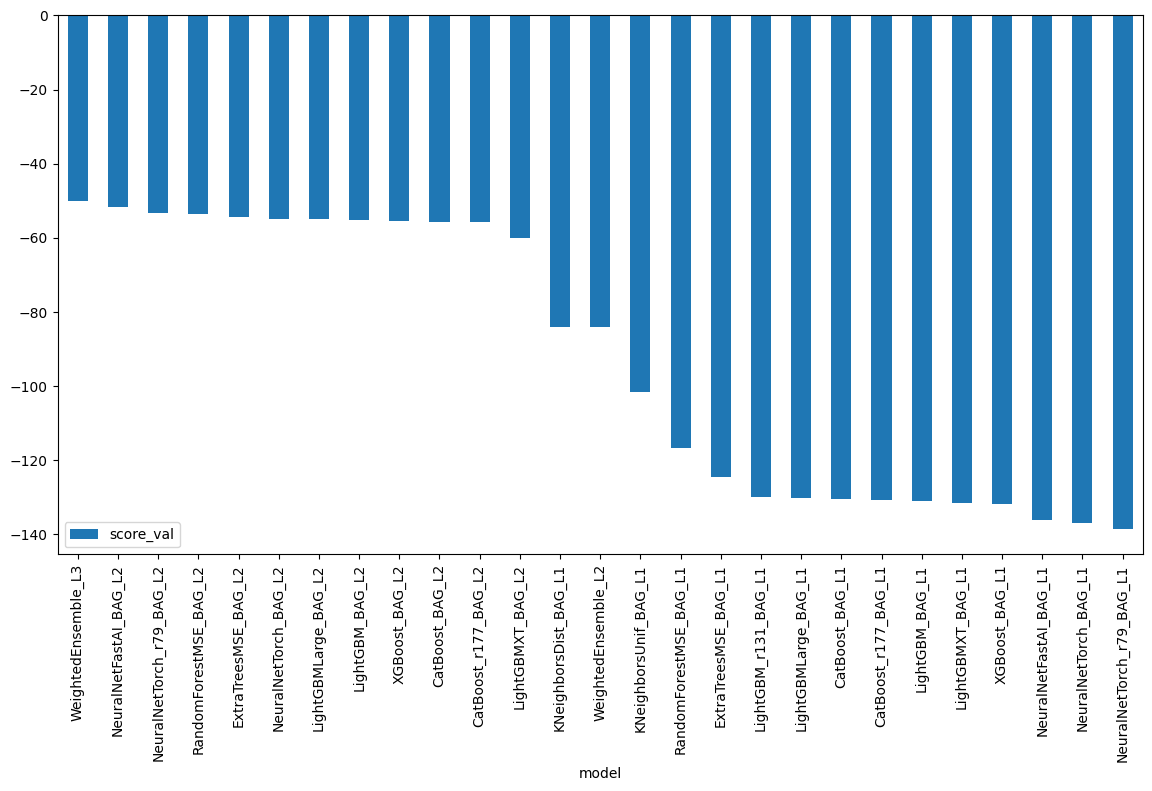

In [13]:
import matplotlib.pyplot as plt
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val", figsize=(14, 7))
plt.show()

### Create predictions from test dataset

In [14]:
predictions = predictor.predict(test)
predictions.head()

0    26.896637
1    40.783520
2    45.495506
3    49.761093
4    51.858849
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [15]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean       99.650139
std        89.589111
min         3.035333
25%        19.464420
50%        63.934860
75%       170.554260
max       351.736511
Name: count, dtype: float64

In [16]:
# How many negative values do we have?
print("Total Predictions: ", len(predictions))
print("Total Positive Predictions: ", (predictions > 0).sum())
print("Total Negative Predictions: ", (predictions < 0).sum())

Total Predictions:  6493
Total Positive Predictions:  6493
Total Negative Predictions:  0


In [17]:
# Set them to zero
if (predictions < 0).any():
    predictions = predictions[predictions < 0] = 0
    print("All Negative values set to zero")
else:
    print("No Negative value in Predictions")

No Negative value in Predictions


### Set predictions to submission dataframe, save, and submit

In [18]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [19]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 737kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [20]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                        description           status                     publicScore  privateScore  
--------------  --------------------------  --------------------  -------------------------  -----------  ------------  
submission.csv  2025-06-09 17:38:29.207000  first raw submission  SubmissionStatus.COMPLETE  1.81758      1.81758       


## Exploratory Data Analysis and Creating additional features

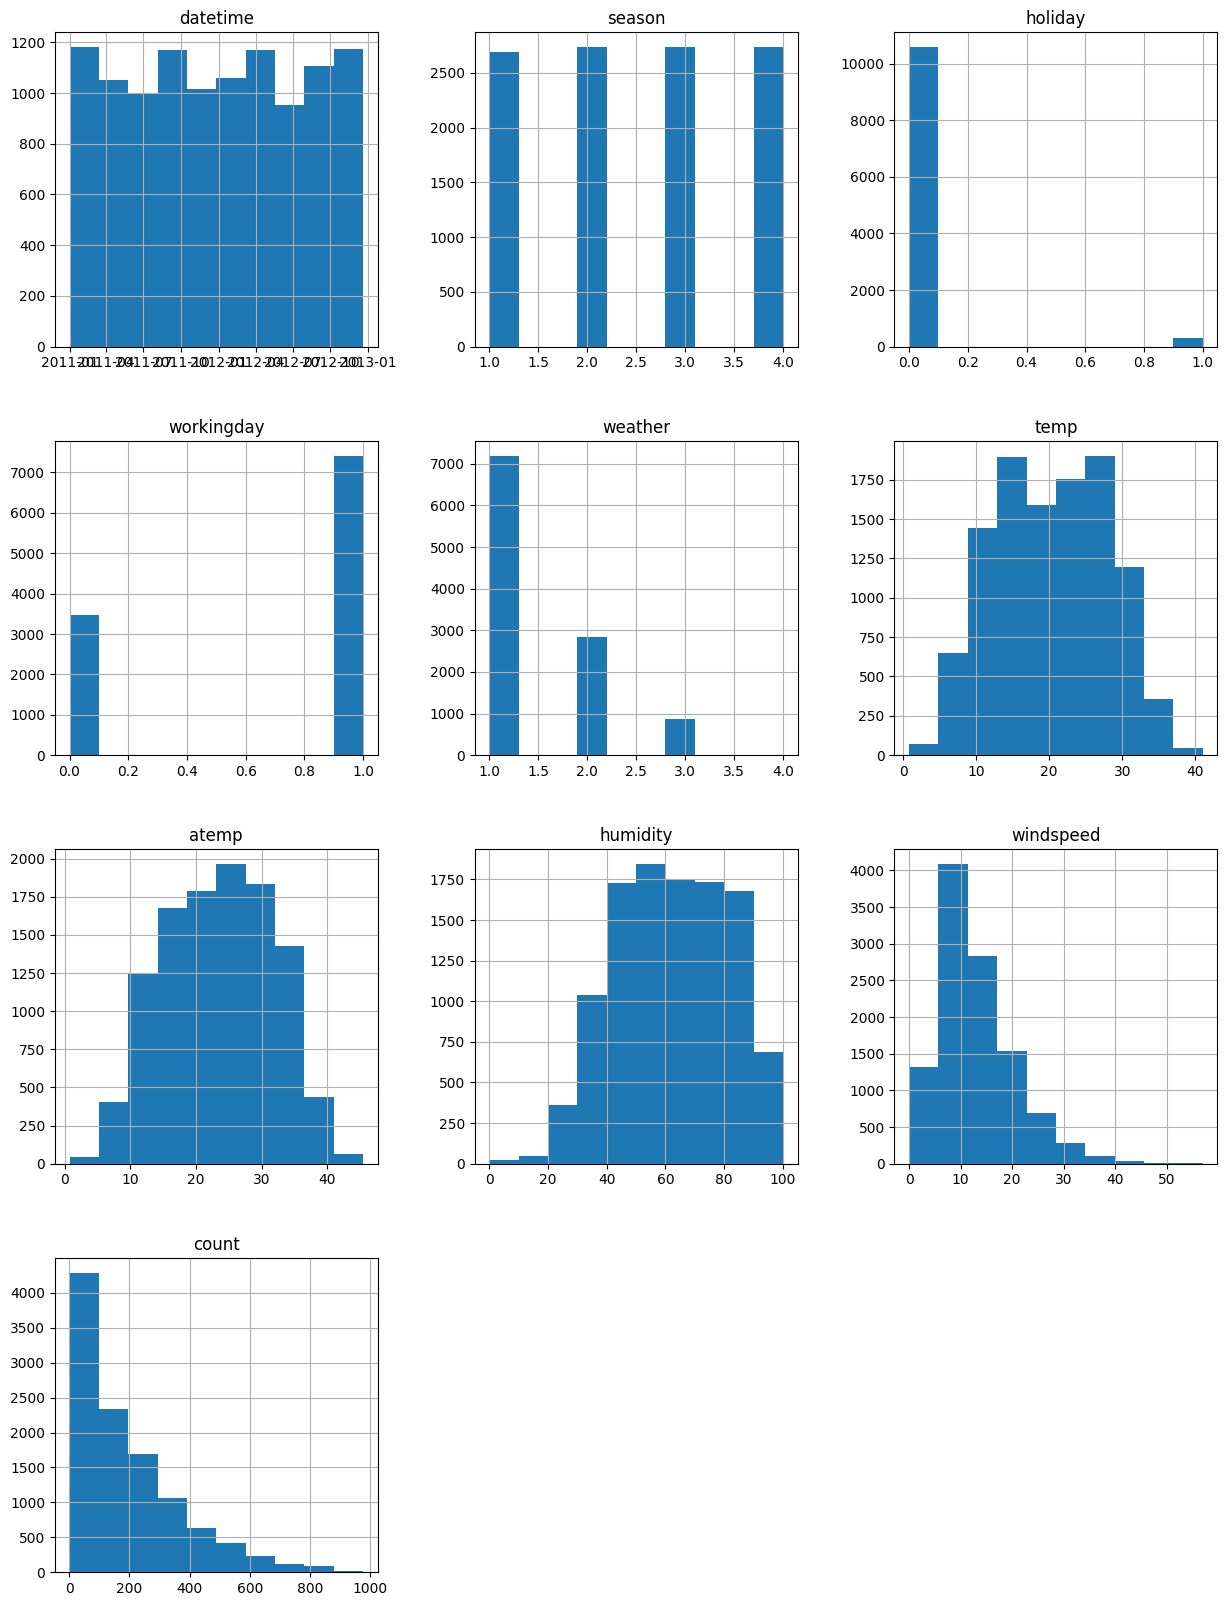

In [21]:
# histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
import matplotlib.pyplot as plt
train.hist(figsize=(15,20))
plt.show()

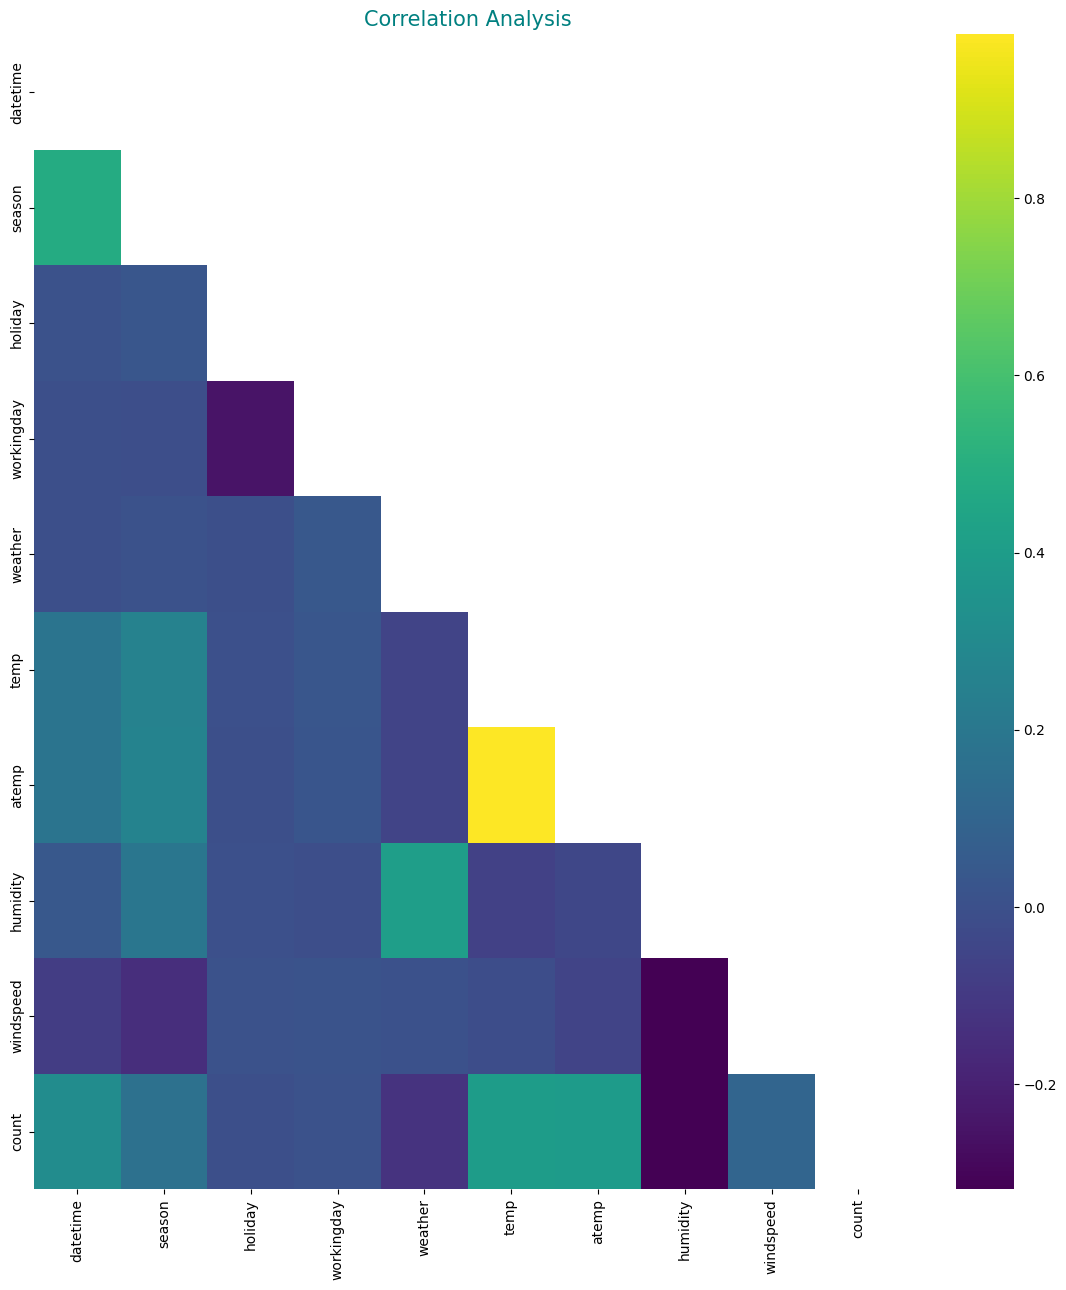

In [22]:
import seaborn as sns
import numpy as np
plt.figure(figsize=(14,15))
corr= train.corr()
mask= np.triu(corr)
plt.title('Correlation Analysis',
         fontsize=15,
         color='teal')
sns.heatmap(corr,
           mask=mask,
           annot=True,
           lw=0,
           linecolor='white',
           cmap='viridis',
           fmt='0.2f')
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [23]:
import datetime
train['datetime'].head()

0   2011-01-01 00:00:00
1   2011-01-01 01:00:00
2   2011-01-01 02:00:00
3   2011-01-01 03:00:00
4   2011-01-01 04:00:00
Name: datetime, dtype: datetime64[ns]

In [24]:
# create a new training data feature
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.dayofweek
train['hour'] = train['datetime'].dt.hour
train.drop(columns='datetime', inplace=True)

In [25]:
# create a new test feature
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.dayofweek
test['hour'] = test['datetime'].dt.hour
test.drop(columns='datetime', inplace=True)

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [26]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')

test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')

In [27]:
# View are new feature
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,5,4


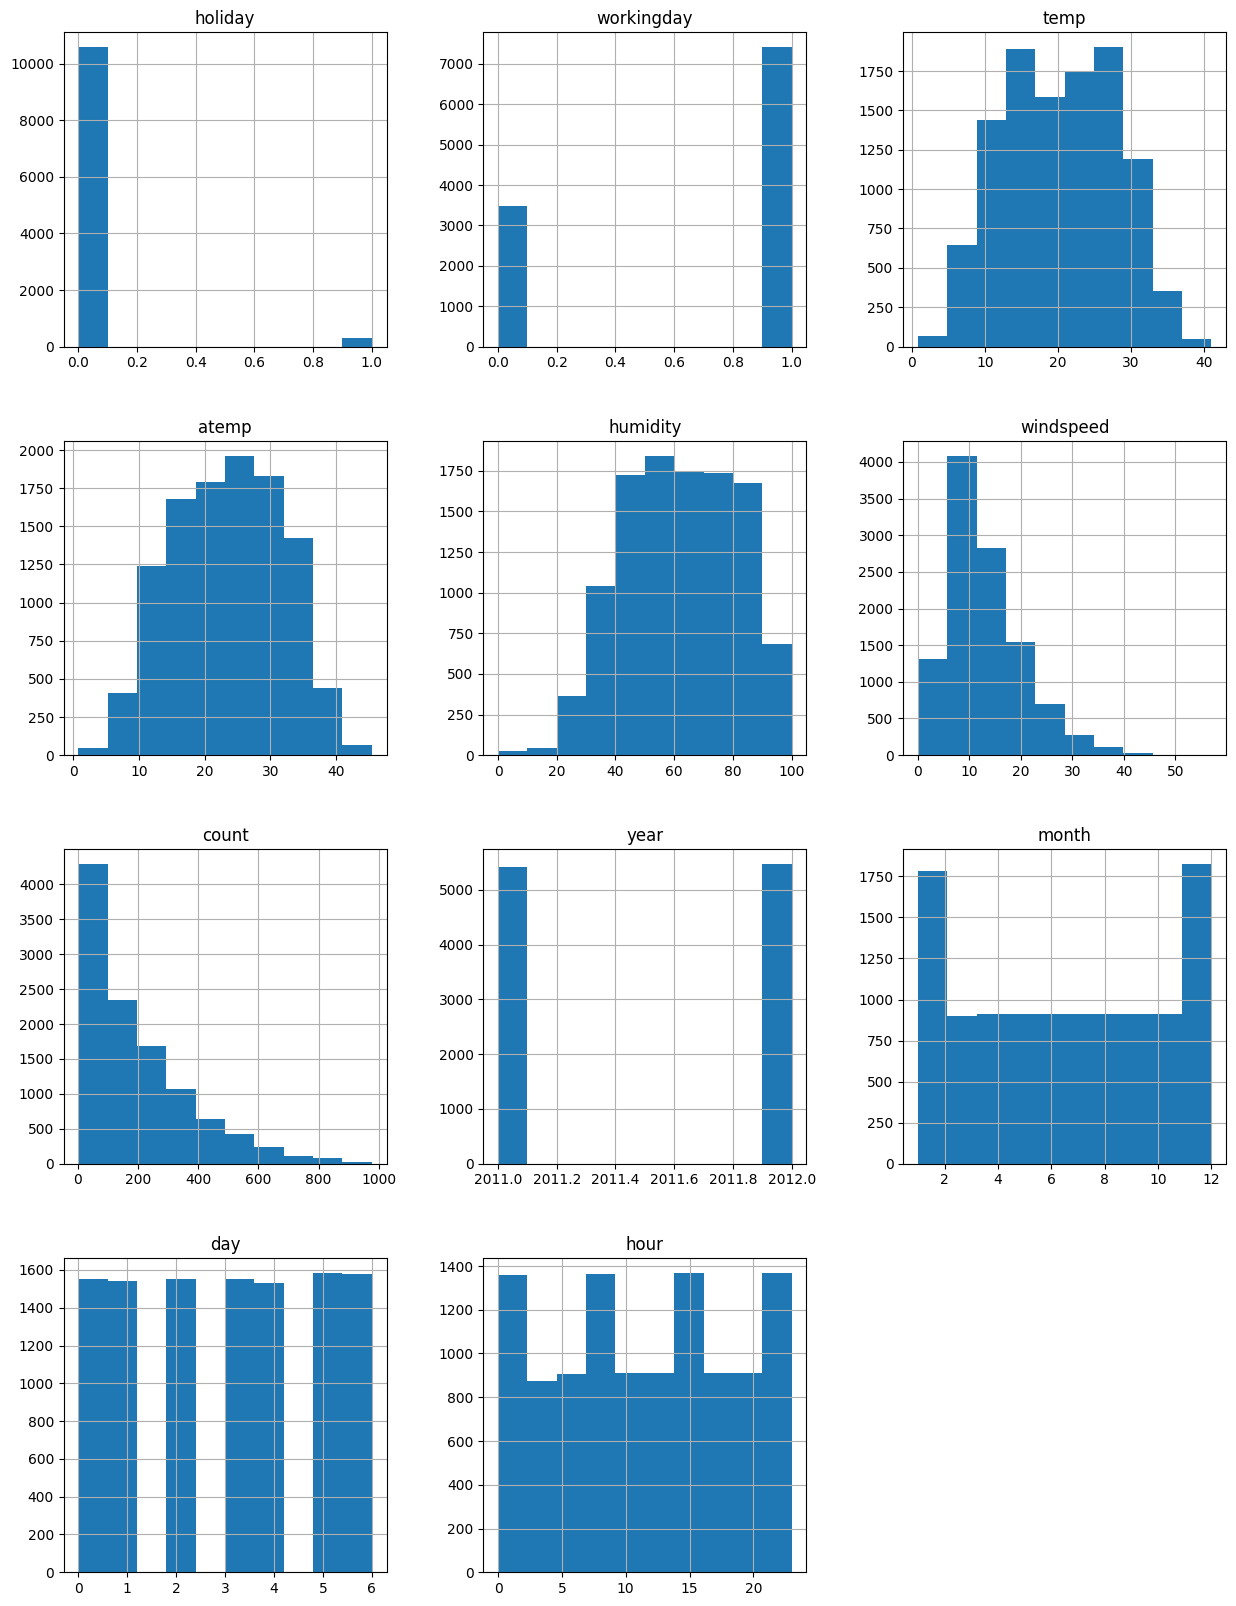

In [28]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(15,20))
plt.show()

## Rerun the model with the same settings as before, just with more features

In [29]:
predictor_new_features = TabularPredictor(label='count',
                            problem_type='regression',
                            eval_metric='root_mean_squared_error'
                            ).fit(train_data = train,
                                 time_limit = 600,
                                 presets= 'best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20250609_173940"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.7
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #63~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 22 19:00:15 UTC 2
CPU Count:          48
Memory Avail:       105.19 GB / 125.63 GB (83.7%)
Disk Space Avail:   644.59 GB / 870.05 GB (74.1%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of A

In [30]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                          model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3  -33.116723  root_mean_squared_error       4.403172  367.731869                0.000306           0.031274            3       True         29
1           WeightedEnsemble_L2  -33.278607  root_mean_squared_error       2.110725  263.304526                0.000342           0.018950            2       True         14
2          CatBoost_r177_BAG_L2  -33.545039  root_mean_squared_error       3.276627  282.631197                0.026994           1.859648            2       True         24
3            CatBoost_r9_BAG_L2  -33.574881  root_mean_squared_error       3.295249  288.471399                0.045615           7.699849            2       True         28
4   NeuralNetFastAI_r191_BAG_L2  -33.597866  root_mean_squared_error

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'NeuralNetTorch_r79_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'Sta

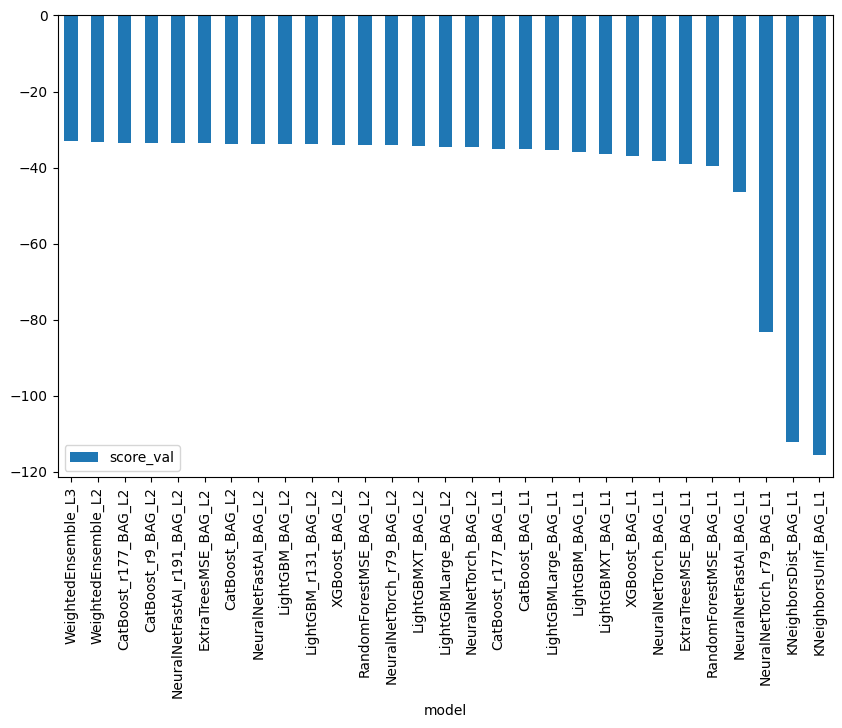

In [31]:
predictor_new_features.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val", figsize=(10, 6))
plt.show()

In [32]:
new_predictions = predictor_new_features.predict(test)
new_predictions.head()

0    13.016307
1     6.034476
2     4.153350
3     3.331968
4     3.216386
Name: count, dtype: float32

In [33]:
new_predictions.describe()

count    6493.000000
mean      189.827927
std       174.371719
min        -1.842135
25%        44.167271
50%       147.120605
75%       282.084015
max       909.021362
Name: count, dtype: float64

In [34]:
# Set negative values to zero
new_predictions[new_predictions < 0] = 0

# Count the total positive and negative predictions
total_predictions = len(new_predictions)
total_positive_predictions = (new_predictions > 0).sum()
total_negative_predictions = (new_predictions < 0).sum()  # Because we set negatives to zero

print("Total Predictions:", total_predictions)
print("Total Positive Predictions:", total_positive_predictions)
print("Total Negative Predictions:", total_negative_predictions)


Total Predictions: 6493
Total Positive Predictions: 6491
Total Negative Predictions: 0


In [35]:
submission_new_features = pd.read_csv("sampleSubmission.csv", parse_dates = ['datetime'])

In [36]:
# Same submitting predictions
submission_new_features["count"] = new_predictions
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [37]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 752kB/s]
Successfully submitted to Bike Sharing Demand

In [38]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                        description           status                     publicScore  privateScore  
---------------------------  --------------------------  --------------------  -------------------------  -----------  ------------  
submission_new_features.csv  2025-06-09 17:51:13.577000  new features          SubmissionStatus.COMPLETE  0.44664      0.44664       
submission.csv               2025-06-09 17:38:29.207000  first raw submission  SubmissionStatus.COMPLETE  1.81758      1.81758       


## Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [41]:
import autogluon.core as ag
## From autogluon documentation

# hyperparameters of models
hyperparameters = {
    'GBM': [
        {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
        {
            "learning_rate": 0.03,
            "num_leaves": 128,
            "feature_fraction": 0.9,
            "min_data_in_leaf": 3,
            "ag_args": {"name_suffix": "Large", "priority": 0, "hyperparameter_tune_kwargs": None},
        }
    ]
}


hyperparameter_tune_kwargs = { 
    'num_trials': 20,
    'scheduler' : 'local',
    'searcher': 'auto',
}

                                            )
predictor_new_hpo = TabularPredictor(
    label='count',
    problem_type='regression',
    eval_metric='root_mean_squared_error'
).fit(
    train_data=train, 
    time_limit=600,
    presets="optimize_for_deployment",
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs={
        'num_trials': 20,
        'scheduler': 'local',
        'searcher': 'auto'
    }
)


No path specified. Models will be saved in: "AutogluonModels/ag-20250609_175632"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.7
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #63~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 22 19:00:15 UTC 2
CPU Count:          48
Memory Avail:       111.88 GB / 125.63 GB (89.1%)
Disk Space Avail:   643.07 GB / 870.05 GB (73.9%)
Presets specified: ['optimize_for_deployment']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "/home/cs/bike-prediction/AutogluonModels/ag-20250609_175632"
Train Data Rows:    10886
Train Data Columns: 12
Label Column:       count
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    114567.89 MB
	Train Data (Original)  Memory Usage: 0.69 MB (0.0% of av

  0%|          | 0/20 [00:00<?, ?it/s]

[1000]	valid_set's rmse: 40.405
[2000]	valid_set's rmse: 39.1724
[3000]	valid_set's rmse: 38.999
[4000]	valid_set's rmse: 38.9087
[1000]	valid_set's rmse: 40.9811
[2000]	valid_set's rmse: 40.0977
[1000]	valid_set's rmse: 40.8436
[2000]	valid_set's rmse: 39.525
[3000]	valid_set's rmse: 39.229
[4000]	valid_set's rmse: 39.1728
[5000]	valid_set's rmse: 39.1791
[1000]	valid_set's rmse: 75.1181
[2000]	valid_set's rmse: 57.0086
[3000]	valid_set's rmse: 50.2572
[4000]	valid_set's rmse: 46.6284
[5000]	valid_set's rmse: 44.2687
[6000]	valid_set's rmse: 42.7848
[7000]	valid_set's rmse: 41.7234
[8000]	valid_set's rmse: 40.9458
[9000]	valid_set's rmse: 40.3953
[10000]	valid_set's rmse: 40.027
[1000]	valid_set's rmse: 40.5095
[2000]	valid_set's rmse: 39.6514
[3000]	valid_set's rmse: 39.6299
[4000]	valid_set's rmse: 39.7562
[1000]	valid_set's rmse: 48.7876
[2000]	valid_set's rmse: 42.014
[3000]	valid_set's rmse: 39.9368
[4000]	valid_set's rmse: 39.2554
[5000]	valid_set's rmse: 38.999
[6000]	valid_set

	Ran out of time, early stopping on iteration 4886. Best iteration is:
	[4883]	valid_set's rmse: 45.0375
	Stopping HPO to satisfy time limit...
Fitted model: LightGBMXT/T1 ...
	-38.8821	 = Validation score   (-root_mean_squared_error)
	5.56s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: LightGBMXT/T2 ...
	-40.0557	 = Validation score   (-root_mean_squared_error)
	8.88s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: LightGBMXT/T3 ...
	-39.1338	 = Validation score   (-root_mean_squared_error)
	11.54s	 = Training   runtime
	0.05s	 = Validation runtime
Fitted model: LightGBMXT/T4 ...
	-40.0268	 = Validation score   (-root_mean_squared_error)
	23.41s	 = Training   runtime
	0.25s	 = Validation runtime
Fitted model: LightGBMXT/T5 ...
	-39.6171	 = Validation score   (-root_mean_squared_error)
	7.39s	 = Training   runtime
	0.03s	 = Validation runtime
Fitted model: LightGBMXT/T6 ...
	-38.8376	 = Validation score   (-root_mean_squared_error)
	28.36s	 = Trainin

[1000]	valid_set's rmse: 38.7165


	-38.6655	 = Validation score   (-root_mean_squared_error)
	4.59s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.00s of the 325.79s of remaining time.
	Ensemble Weights: {'LightGBMLarge': 0.52, 'LightGBMXT/T6': 0.48}
	-37.0281	 = Validation score   (-root_mean_squared_error)
	0.0s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 274.23s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 11807.2 rows/s (2178 batch size)
Deleting model LightGBMXT/T1. All files under /home/cs/bike-prediction/AutogluonModels/ag-20250609_175632/models/LightGBMXT/T1 will be removed.
Deleting model LightGBMXT/T2. All files under /home/cs/bike-prediction/AutogluonModels/ag-20250609_175632/models/LightGBMXT/T2 will be removed.
Deleting model LightGBMXT/T3. All files under /home/cs/bike-prediction/AutogluonModels/ag-20250609_175632/models/LightGBMXT/T3 will be removed.
Deleting

In [42]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val              eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2 -37.028065  root_mean_squared_error       0.184464  32.946548                0.000204           0.003851            2       True          3
1        LightGBMLarge -38.665468  root_mean_squared_error       0.009960   4.587687                0.009960           4.587687            1       True          2
2        LightGBMXT/T6 -38.837610  root_mean_squared_error       0.174300  28.355010                0.174300          28.355010            1       True          1
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'LGBModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('category', [])  : 2 | ['season', 'weather']
('float', [])     : 3 | ['t

{'model_types': {'LightGBMXT/T6': 'LGBModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMXT/T6': -38.83760950479311,
  'LightGBMLarge': -38.66546787903407,
  'WeightedEnsemble_L2': -37.02806456177329},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBMXT/T6': ['LightGBMXT', 'T6'],
  'LightGBMLarge': ['LightGBMLarge'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2']},
 'model_fit_times': {'LightGBMXT/T6': 28.35500955581665,
  'LightGBMLarge': 4.587687015533447,
  'WeightedEnsemble_L2': 0.0038509368896484375},
 'model_pred_times': {'LightGBMXT/T6': 0.174299955368042,
  'LightGBMLarge': 0.009959936141967773,
  'WeightedEnsemble_L2': 0.0002040863037109375},
 'num_bag_folds': 0,
 'max_stack_level': 2,
 'model_hyperparams': {'LightGBMXT/T6': {'learning_rate': 0.017357968430552234,
   'extra_trees': True,
   'feature_fraction': 0.9590196908843444,
   'min_data_in_leaf': 22,
   'num_leaves': 96},
  'LightGBML

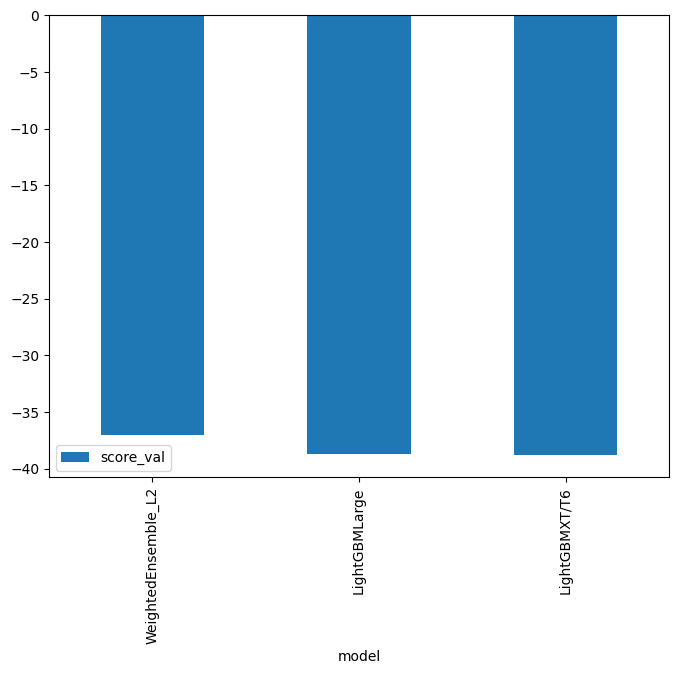

In [43]:
predictor_new_hpo.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val", figsize=(8, 6))
plt.show()

In [44]:
hypo_predictions = predictor_new_hpo.predict(test)
hypo_predictions.head()

0    18.253317
1     5.819321
2     3.653975
3     2.033371
4     3.024155
Name: count, dtype: float32

In [45]:
len(hypo_predictions)

6493

In [46]:
# Set negative values to zero
hypo_predictions[hypo_predictions < 0] = 0

# Count the total positive and negative predictions
total_predictions = len(hypo_predictions)
total_positive_predictions = (hypo_predictions > 0).sum()
total_negative_predictions = (hypo_predictions < 0).sum()  # Because we set negatives to zero

print("Total Predictions:", total_predictions)
print("Total Positive Predictions:", total_positive_predictions)
print("Total Negative Predictions:", total_negative_predictions)


Total Predictions: 6493
Total Positive Predictions: 6399
Total Negative Predictions: 0


In [47]:
submission_new_hpo = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])

In [48]:
# Same submitting predictions
submission_new_hpo["count"] = hypo_predictions
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [49]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 659kB/s]
Successfully submitted to Bike Sharing Demand

In [50]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                        description                        status                     publicScore  privateScore  
---------------------------  --------------------------  ---------------------------------  -------------------------  -----------  ------------  
submission_new_hpo.csv       2025-06-09 18:06:48.793000  new features with hyperparameters  SubmissionStatus.COMPLETE  0.53854      0.53854       
submission_new_features.csv  2025-06-09 17:51:13.577000  new features                       SubmissionStatus.COMPLETE  0.44664      0.44664       
submission.csv               2025-06-09 17:38:29.207000  first raw submission               SubmissionStatus.COMPLETE  1.81758      1.81758       


#### New Score of `0.5415`

## Project Report
### Refer to the markdown file for the full report
### Creating plots and table for report

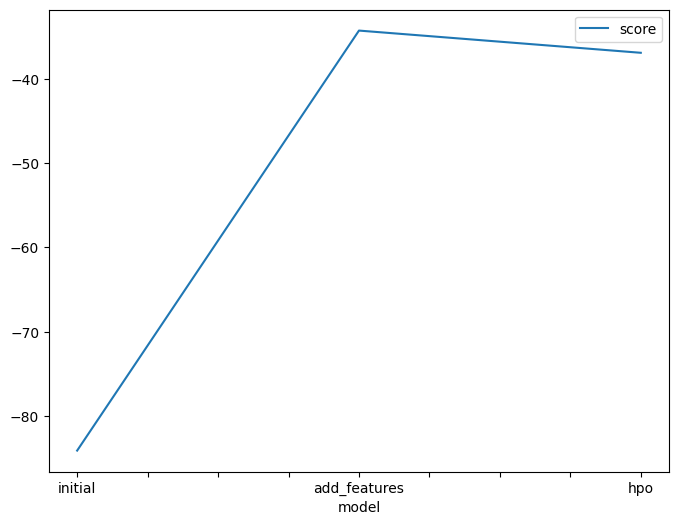

In [51]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-84.125061, -34.238004, -36.875898]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

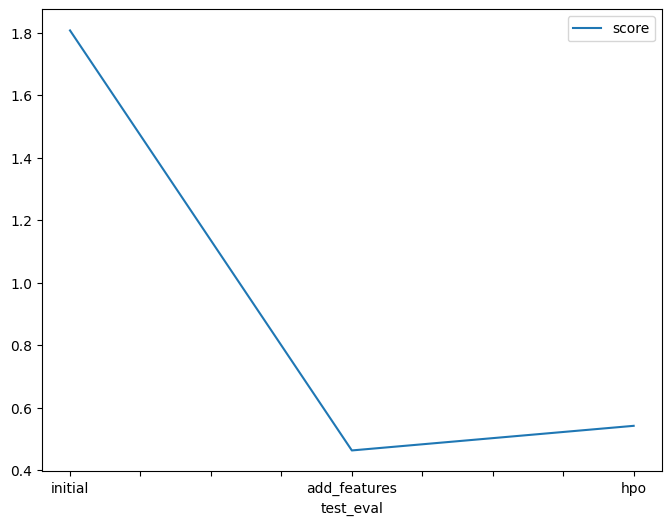

In [52]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80758, 0.46268, 0.5415]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [53]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ['default_params', 'default_params', 'GBM: num_leaves: lower=26, upper=66'],
    "hpo2": ['default_params', 'default_params', 'NN: dropout_prob: 0.0, 0.5'],
    "hpo3": ['default_params', 'default_params', 'GBM: num_boost_round: 100'],
    "score": [1.80758, 0.46268, 0.5415]
})

,model,hpo1,hpo2,hpo3,score
0,initial,default_params,default_params,default_params,1.80758
1,add_features,default_params,default_params,default_params,0.46268
2,hpo,"GBM: num_leaves: lower=26, upper=66","NN: dropout_prob: 0.0, 0.5",GBM: num_boost_round: 100,0.54150


## Summary:
The best perfomed model is `predictor_new_features` (model with new features) with RMSE Score of 0.46268